In [1]:
import numpy as np
#np.seterr(all='raise') oder warn
#auskommentiert, da sonst das Mischmodell FloatingPointError liefert
#Warum dürfen wir die FloatingPointError ignorieren???
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize as opt
from matplotlib.dates import (YEARLY, DateFormatter,
                              MonthLocator, drange)
import datetime

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
covid = pd.read_csv('./time_series_covid19_confirmed_global.csv', delimiter= ",")
germany_data = covid[covid["Country/Region"] == "Germany"]
covidDates = germany_data.keys()[4:]
covidDates = np.array(covidDates)

In [3]:
yData = []
for i in range(1, len(covidDates)):
    yData.append(int(germany_data[covidDates[i]].values) - int(germany_data[covidDates[i - 1]].values))
yData = np.array(yData)

In [4]:
#Methoden um besser mit den Daten arbeiten zu können
def returnDayAndMonth(dateString):
    month, day, year = dateString.split("/")
    return day, month

def convertDayAndMonthToISODate(day, month):
    dateString= "2020-"
    if len(month) == 1:
        dateString += "0"
    dateString += month
    dateString += "-"
    if len(day) == 1:
        dateString += "0"
    dateString += day
    return datetime.date.fromisoformat(dateString)

def toDatetimeDate(dateString):
    return convertDayAndMonthToISODate(*returnDayAndMonth(dateString))

def getIndex(dateString):
    return np.where([covidDates == dateString])[1][0]

In [5]:
#initialize important dates and dateIndizes
jan23 = "1/23/20"
jan27 = "1/27/20"
may31 = "5/31/20"
june30 = "6/30/20"
july1 = "7/1/20"
july2 = "7/2/20"
nov30 = "11/30/20"
dez15 = "12/15/20"
dez25 = "12/25/20"

jan27Index = getIndex(jan27)
may31Index = getIndex(may31)
june30Index = getIndex(june30)
july1Index = getIndex(july1)
july2Index = getIndex(july2)
nov30Index = getIndex(nov30)
dez15Index = getIndex(dez15)

In [6]:
def plotMonthlyDate(ax, firstDate, lastDate, yData, labelParam, colorParam="blue"):
    loc = MonthLocator()
    formatter = DateFormatter("%b")
    firstCovidDate = toDatetimeDate(firstDate)
    lastCovidDate = toDatetimeDate(lastDate) + datetime.timedelta(days=1)
    delta = datetime.timedelta(days=1)
    dates = drange(firstCovidDate, lastCovidDate, delta)

    ax.plot_date(dates, yData, "b-", color=colorParam, label=labelParam)
    ax.legend(loc="upper left", prop={'size': 6})
    ax.xaxis.set_major_locator(loc)
    ax.xaxis.set_major_formatter(formatter)
    ax.xaxis.set_tick_params(labelsize=12)
    ax.set_facecolor("0.9")
    plt.xlim(dates[0] - 1, dates[-1] + 1)

In [7]:
#kann ignoriert werden (nur für's Aussehen)
def fixAspectRatio(ax, desiredRatio):
    xleft, xright = ax.get_xlim()
    ybottom, ytop = ax.get_ylim()
    ax.set_aspect(abs((xright-xleft)/(ybottom-ytop)) * desiredRatio)

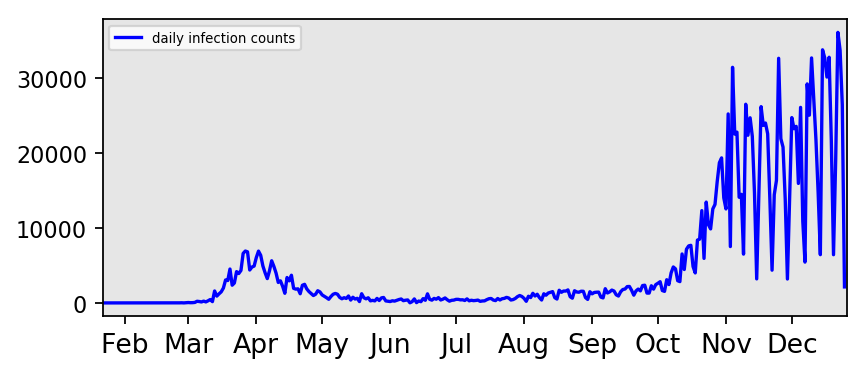

In [8]:
fig = plt.figure(dpi=160)
ax = plt.subplot(111)
plotMonthlyDate(ax, jan23, dez25, yData, "daily infection counts")
fixAspectRatio(ax, 0.4)
plt.show()

In [9]:
def calculateMovingAverage(yData):
    movingAverageData = []
    maxIndex = len(yData) - 1
    for fixedPosition in range(0, len(yData)):
        sum = 0
        number = 0
        for relativePosition in range(-3, 4):
            currentPosition = fixedPosition + relativePosition
            if currentPosition >= 0 and currentPosition <= maxIndex:
                sum += yData[currentPosition]
                number += 1.0
        movingAverageData.append(sum / number)
    return movingAverageData

movingAverageData = calculateMovingAverage(yData)

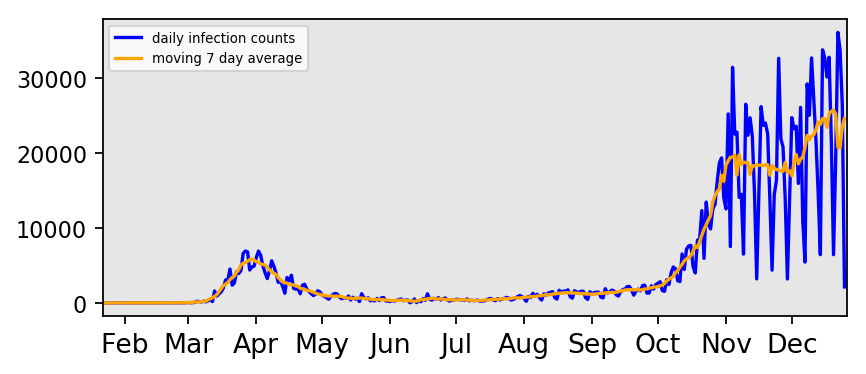

In [10]:
fig = plt.figure(dpi=160)
ax = plt.subplot(111)
plotMonthlyDate(ax, jan23, dez25, yData, "daily infection counts")
plotMonthlyDate(ax, jan23, dez25, movingAverageData, "moving 7 day average", "orange")
fixAspectRatio(ax, 0.4)
plt.show()

In [11]:
jan27ToMay31MAData = movingAverageData[(jan27Index-1):may31Index]

In [12]:
def gompertzFct(t, N, r, t0):
    return N * (np.exp((-1.)*r*(t-t0) - np.exp((-1.)*r*(t-t0)))) * r

In [13]:
I_trn = jan27ToMay31MAData
# - 4 im Folgenden immer, da Januar 27 der 0te Index sein soll und jan27Index = 4 ist
t_trn = [n for n in range(0, may31Index - 4)]

guess = (100000, 0.09, 60)

parameters, covariance = opt.curve_fit(gompertzFct, t_trn, I_trn, p0=guess)

xValues = [n for n in range(0, getIndex("6/30/20") - 4)]
I = gompertzFct(xValues, *parameters)

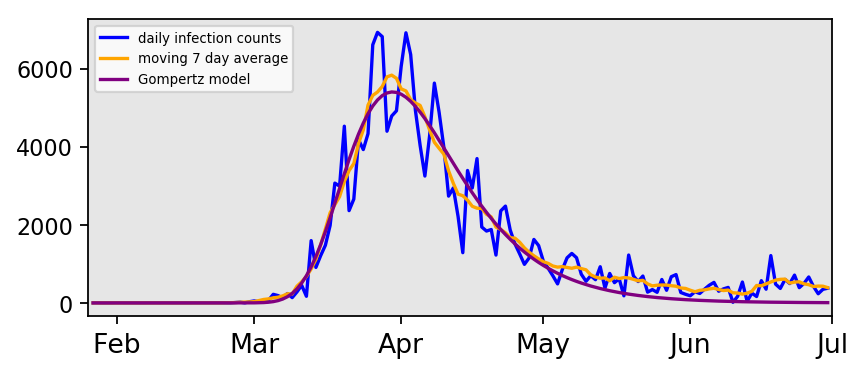

In [14]:
fig = plt.figure(dpi=160)
ax = plt.subplot(111)
plotMonthlyDate(ax, jan27, june30, yData[(jan27Index-1):june30Index], "daily infection counts")
plotMonthlyDate(ax, jan27, june30, movingAverageData[(jan27Index-1):june30Index], "moving 7 day average", "orange")
plotMonthlyDate(ax, jan27, june30, I, "Gompertz model", "purple")
fixAspectRatio(ax, 0.4)
plt.show()

In [15]:
july1ToNov30MAData = movingAverageData[(july1Index-1):nov30Index]

In [16]:
I_trn = july1ToNov30MAData
t_trn = [n for n in range((july1Index-1) - 4, nov30Index - 4)]

guess = (1300000, 0.08, 300)

parameters, covariance = opt.curve_fit(gompertzFct, t_trn, I_trn, p0=guess)
xValues = [n for n in range((getIndex("7/2/20")-1) - 4, getIndex("12/15/20") - 4)]
I = gompertzFct(xValues, *parameters)

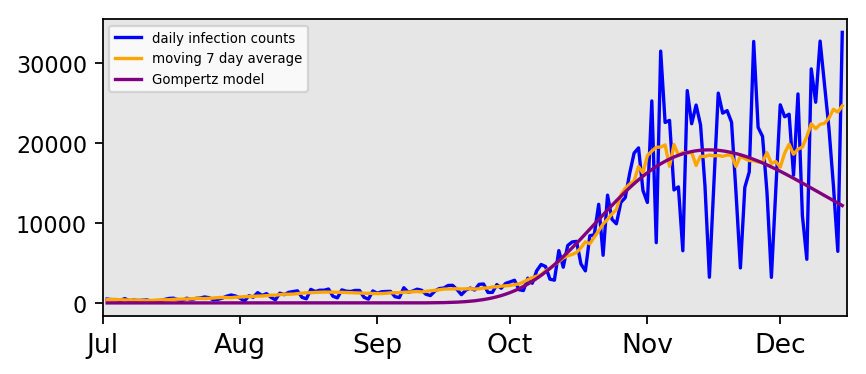

In [17]:
fig = plt.figure(dpi=160)
ax = plt.subplot(111)
plotMonthlyDate(ax, july2, dez15, yData[(july2Index-1):dez15Index], "daily infection counts")
plotMonthlyDate(ax, july2, dez15, movingAverageData[(july2Index-1):dez15Index], "moving 7 day average", "orange")
plotMonthlyDate(ax, july2, dez15, I, "Gompertz model", "purple")
fixAspectRatio(ax, 0.4)
plt.show()

In [18]:
def mixedModel(t, N1, r1, t01, N2, r2, t02):
    return (gompertzFct(t, N1, r1, t01) + gompertzFct(t, N2, r2, t02))

In [19]:
jan27ToNov30MAData = movingAverageData[(jan27Index-1):nov30Index]

In [20]:
I_trn = jan27ToNov30MAData
t_trn = [n for n in range(0, nov30Index - 4)]

guess = (100000, 0.09, 60, 1300000, 0.08, 300)

parameters, covariance = opt.curve_fit(mixedModel, t_trn, I_trn, p0=guess)

xValues = [n for n in range(0, dez15Index - 4)]
I = mixedModel(xValues, *parameters)

# "FloatingPointError: underflow encountered in multiply" kommt, wenn man ganz am Anfang 
# "np.seterr(all='raise')" nicht auskommentiert. Warum kann das ignoriert werden??
# FloatingPointError treten bereits auf, wenn man ein Gompertz-Modell an den gesamten Zeitraum
# mit den zweiten guess Parametern (1300000, 0.08, 300) versucht anzugleichen.

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: underflow encountered in multiply
  


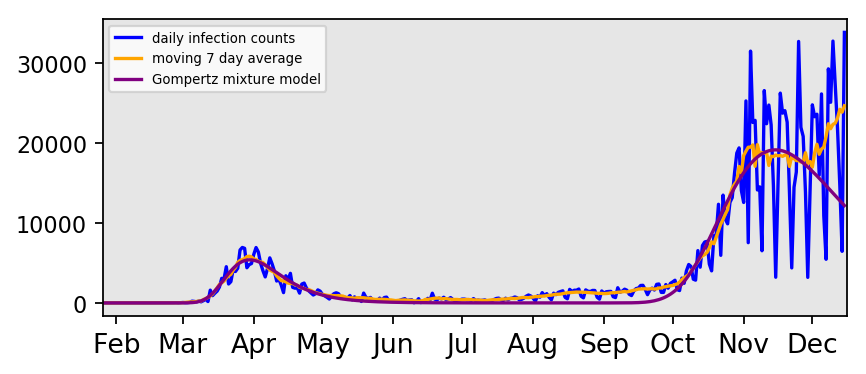

In [21]:
fig = plt.figure(dpi=160)
ax = plt.subplot(111)
plotMonthlyDate(ax, jan27, dez15, yData[(jan27Index-1):dez15Index], "daily infection counts")
plotMonthlyDate(ax, jan27, dez15, movingAverageData[(jan27Index-1):dez15Index], "moving 7 day average", "orange")
plotMonthlyDate(ax, jan27, dez15, I, "Gompertz mixture model", "purple")
fixAspectRatio(ax, 0.4)
plt.show()

Bei großen Zahlen kann es zu Rundungsfehlern kommen. Deshalb ist es sinnvoller mit niedrigeren Werten zu rechnen.